
# Transfer Learning

Na maioria das vezes, você não vai querer treinar toda uma rede convolucional. O treinamento moderno do ConvNets em grandes datasets como o ImageNet leva semanas em várias GPUs.
> Em vez disso, a maioria das pessoas usa uma rede pré-treinada como um extrator de features fixo ou como uma rede inicial para ser treinada.

Neste notebook, você usará a [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) treinada no [dataset ImageNet](http://www.image-net.org/) como um extrator de features. Abaixo está um diagrama da arquitetura VGGNet, com uma série de camadas convolucionais e de maxpooling, e depois três camadas lineares no final, que classificam as 1000 classes encontradas no dataset ImageNet.

<img src="notebook_ims/vgg_16_architecture.png" width=700px>

A VGGNet é ótima porque é simples e tem ótimo desempenho, ficando em segundo lugar na competição ImageNet. A idéia aqui é que mantenhamos todas as camadas convolucionais, mas que a gente **substitua a camada linear final** por nosso próprio classificador. Dessa forma, podemos usar a VGGNet como um extrator de features fixo para nossas imagens e treinar facilmente um classificador simples.
* Use todos, exceto a última camada linear, como um extrator de features fixo.
* Defina uma nova camada final de classificação e aplique-a em uma tarefa de nossa escolha!

Você pode ler mais sobre transfer learning nas [notas de aula do curso do CS231n Stanford](http://cs231n.github.io/transfer-learning/).


## Flores

Aqui vamos usar a VGGNet para classificar imagens de flores. Começaremos, como sempre, importando nossos recursos habituais e verificando se podemos treinar nosso modelo em GPU.

### Download dos dados

Faça o download dos dados das flores [neste link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/Setembro/5baa60a0_flower-photos/flower-photos.zip), salve-os no diretório raíz deste notebook e extraia o arquivo zip para obter o diretório `flower_photos/`. **Verifique se o diretório tem esse nome exato para acessar os dados: flower_photos**.

In [1]:
from __future__ import print_function, division
import plotly.graph_objects as go
import plotly.figure_factory as ff
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy

%matplotlib inline

In [2]:
# Checando se CUDA está disponível
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


## Load and Transform our Data

Iremos utilizar a classe [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) do PyTorch que facilita a carga dos dados a partir do disco rígido. Por exemplo, as imagens de treinamento estão ordenadas em um caminho que possui o seguinte padrão:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Nesse caso, o diretório raíz para treinamento é `flower_photos/train/` e as classes são os nomes dos tipos das flores.

In [3]:
# definindo diretórios de treinamento, teste e validação
data_dir = 'flower_photos/'

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')


# classes são pastas em cada diretório com esses nomes
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Transformando os Dados

Ao realizar transfer learning, precisamos modelar os dados de entrada de tal forma que possuam o mesmo formato que a rede pré-treinada espera receber. A VGG16 espera receber, como entrada, imagens quadradas de dimensões 224, então precisamos reformatar as imagens de flores para este formato.

In [4]:
# carregando e transformando dados usando ImageFolder

# VGG-16 recebe imagens de entrada 224x224, então vamos redimensioná-las
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])





train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)



# vamos ver algumas estatísticas das imagens
print('Num training images: ', len(train_data))
print('Num val images: ', len(val_data))
print('Num test images: ', len(test_data))

Num training images:  2658
Num val images:  472
Num test images:  540


In [5]:
batch_size = 20
num_workers=1

# data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

train_size = len(train_loader)
val_size = len (val_loader)
test_size = len(test_loader)

print(len(train_loader))

133


### DataLoaders e Data Visualization

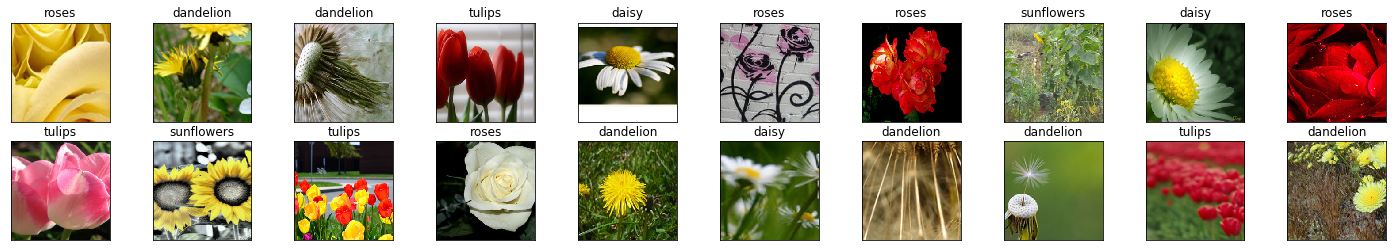

In [22]:
# Visualizando alguns dados

# Obtendo um batch do conjunto de treinamento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convertemos a imagem para numpy para podermos visualizá-la

# Visualizando as imagens do batch junto com suas respectivas labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Definindo o Modelo

Para definir o modelo, vamos seguir os seguintes passos:
1. Carregar o modelo VGG16 pré-treinado
2. "Congelar" todos os parâmetros, para que a extração de características fique fixa
3. Remover a última camada
4. Substituir a última camada por um classificador linear novo

**Congelar simplesmente significa que os parâmetros no modelo pré-treinado *não* serão alterados durante o treinamento**

In [7]:
# Carregando o modelo a partir do PyTorch
vgg16 = models.vgg16(pretrained=True)

# Vamos ver a estrutura do modelo
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 


4096
1000


In [9]:
# Congelando o treinamento para todas as camadas de "features"
for param in vgg16.features.parameters():
    param.requires_grad = False

### Camada final do classificador

Depois de ter o extrator de features pré-treinado, basta modificar e/ou adicionar às camadas classificadoras finais lineares. Nesse caso, sugerimos que você altere a última camada do grupo de classificadores da vgg.
> Essa camada deve ver como entrada o número de features produzidas pela parte da rede que você não está alterando e produzir um número apropriado de saídas para a tarefa de classificação de flores.

Você pode acessar qualquer camada em uma rede pré-treinada por nome e número (às vezes), ou seja, `vgg16.classifier[6]` é a sétima camada em um grupo de camadas chamado "classificador".

#### TODO: Substitua a última camada linear por uma que produza o número apropriado de classes desejadas.

In [10]:
# Newly created modules have require_grad=True by default


num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(classes))]) # Add our layer with 5 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Defina a [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) e o [Optimizer](http://pytorch.org/docs/stable/optim.html)

Agora, vamos utilizar a cross-entropy loss e o gradiente descendente estocástico com um learning rate baixo. Note que o otimizador aceita, como entrada, _apenas_ os parâmetros treináveis `vgg.classifier.parameters()`.

In [11]:
if train_on_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side

# Especificando a função de loss (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Especificando o otimizador e learning rate
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)


---
## Treinamento

Vamos treinar a rede.
> **Exercício:** Aqui, vou deixar por sua conta a implementação do código de treinamento. Basicamente, o código aqui não difere muito do loop de treinamento que sempre é feito com o PyTorch. Note que não estamos utilizando conjunto de validação aqui. Opcionalmente, você pode criar o conjunto de validação e realizar o treinamento como deveria ser (recomendo que você faça assim). **O conjunto de validação deve ser extraído do conjunto de treinamento, não de test**. Garanta que os conjuntos estejam sempre balanceados. Não se esqueça de plotar as linhas de loss de treino e validação e de implementar o early stopping. Imprima sua acurácia final, matriz de confusão e suas métricas. Teste o seu loop com apenas duas épocas, mas quando estiver seguro que o código está correto, aumente as épocas até que o treinamento seja sempre interrompido pelo early stopping e não pelo fim das épocas.

In [12]:
#Número de épocas
# n_epochs = 2

## TODO: complete os loops de treinamento das épocas com batch
## Esses loops devem atualizar os pesos do classificador do modelo
## e rastrear o loss no decorrer do tempo.


def train_model(vgg, criterion, optimizer, num_epochs=2,max_epochs_stop=3):
    
    epochs_no_improve = 0
    val_loss_min = np.Inf
    val_max_acc = 0
    history = []

    
    for epoch in range(num_epochs):
        print("Época {}/{}".format(epoch+1, num_epochs))

        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0


        vgg.train(True)
        
        for inputs, labels in train_loader:
          
            
            inputs, labels = inputs.cuda() ,labels.cuda()

            optimizer.zero_grad()
            
            output = vgg(inputs)
    
            loss = criterion(output, labels)
            
            loss.backward()

            optimizer.step()
            

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            acc_train += accuracy.item() * inputs.size(0) 


            loss_train += loss.item()*inputs.size(0)       

                  
            del inputs, labels, output, pred
            torch.cuda.empty_cache()
        
        vgg.train(False)
        vgg.eval()  
        
        for inputs, labels in val_loader:


            inputs, labels = inputs.cuda() , labels.cuda()

            optimizer.zero_grad()

            output = vgg(inputs)
            
            # Calculate validation accuracy
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(
            correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples
            acc_val += accuracy.item() * inputs.size(0)  

            loss = criterion(output, labels)
            loss_val += loss.item()*inputs.size(0)   
            
            
            del inputs, labels, output, pred
            torch.cuda.empty_cache()


        # Calculate average train
        train_loss  = loss_train  / len(train_loader.dataset)   
        train_acc  = acc_train  / len(train_loader.dataset)    

        # Calculate average val
        val_loss = loss_val / len(val_loader.dataset)
        val_acc = acc_val / len(val_loader.dataset)


        history.append([train_loss, val_loss, train_acc, val_acc])

        # Print training and validation results
        print(f'\nPerda treinamento: {train_loss:.4f} \tPerda validação: {val_loss:.4f}' )
        print(f'Acurácia treinamento: {100 * train_acc:.2f}%\t Acurácia validação: {100 * val_acc:.2f}%' )
        print('-' * 11)
        print()

        if val_loss < val_loss_min:
         # Track improvement
            epochs_no_improve = 0
            val_loss_min = val_loss
            val_best_acc = val_acc
            best_epoch = epoch

        else:
            epochs_no_improve += 1
                    # Trigger early stopping
            if epochs_no_improve >= max_epochs_stop:
                  print(f'\nEarly Stopping! Total de épocas: {epoch+1}. Melhor época: {best_epoch+1}, perda: {val_loss_min:.2f} acurácia: {100 * val_best_acc:.2f}%'
                        )
                  df = pd.DataFrame(history,columns=['train_loss', 'val_loss', 'train_acc','val_acc' ])
                  return vgg, df


    df = pd.DataFrame(
    history, columns=['train_loss', 'val_loss', 'train_acc', 'val_acc'])
    
    return vgg ,df               


In [13]:
vgg16New, df = train_model(vgg16, criterion, optimizer, num_epochs=25, max_epochs_stop=3)

Época 1/25

Perda treinamento: 1.1850 	Perda validação: 0.8984
Acurácia treinamento: 56.25%	 Acurácia validação: 72.25%
-----------

Época 2/25

Perda treinamento: 0.8322 	Perda validação: 0.7237
Acurácia treinamento: 72.08%	 Acurácia validação: 77.75%
-----------

Época 3/25

Perda treinamento: 0.7089 	Perda validação: 0.6655
Acurácia treinamento: 75.51%	 Acurácia validação: 79.45%
-----------

Época 4/25

Perda treinamento: 0.6522 	Perda validação: 0.6071
Acurácia treinamento: 76.64%	 Acurácia validação: 77.54%
-----------

Época 5/25

Perda treinamento: 0.6074 	Perda validação: 0.5870
Acurácia treinamento: 78.37%	 Acurácia validação: 80.08%
-----------

Época 6/25

Perda treinamento: 0.6007 	Perda validação: 0.5603
Acurácia treinamento: 78.59%	 Acurácia validação: 81.78%
-----------

Época 7/25

Perda treinamento: 0.5688 	Perda validação: 0.5679
Acurácia treinamento: 78.97%	 Acurácia validação: 80.51%
-----------

Época 8/25

Perda treinamento: 0.5722 	Perda validação: 0.5521
Acurác

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index+1, y=df['train_loss'],
                    mode='lines',
                    name='Treinamento<br> perda'))
fig.add_trace(go.Scatter(x=df.index+1, y=df['val_loss'],
                    mode='lines',
                    name='Validação<br>perda'))
fig.update_layout(
template='plotly_dark', font={'size':15,'color':'white'}, 
xaxis={'title':'Época   '},
yaxis={'title':'Média da probilidade negativa do log'}, 
title={'text':'Perda','x':0.5,'y':0.96 }
)
fig.show()


In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index+1, y=df['train_acc'],
                    mode='lines',
                    name='Treinamento<br>acurácia'))
fig.add_trace(go.Scatter(x=df.index+1, y=df['val_acc'],
                    mode='lines',
                    name='Validação<br>acurácia'))
fig.update_layout(
template='plotly_dark', font={'size':15,'color':'white'}, 
xaxis={'title':'Época   '},
yaxis={'title':'Acurácia média'}, 
title={'text':'Acurácia','x':0.5,'y':0.96 }
)
fig.show()

---
## Testando

Abaixo, vamos checar a acurácia para cada classe de flor. Adapte esse código para obter as métricas pedidas no exercício.

In [23]:
# track test loss 
# over 5 flower classes

test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
matriz_confusao_absoluta = [[0]*5 for i in range(5)]
matriz_confusao_relativa = [[0]*5 for i in range(5)]
class_predi = [[0]*5 for i in range(5)]


vgg16New.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16New(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class


    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        matriz_confusao_absoluta[label][pred[i]] += 1
        #print(label,pred[i])

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
#print('Perda teste:(Total) {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Acurácia teste %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Acurácia teste  %5s: N/A (no training examples)' % (classes[i]))

print('\nAcurárica teste (Total): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



Acurácia teste daisy: 84% (78/92)
Acurácia teste dandelion: 90% (120/132)
Acurácia teste roses: 74% (68/91)
Acurácia teste sunflowers: 84% (85/101)
Acurácia teste tulips: 76% (95/124)

Acurárica teste (Total): 82% (446/540)


In [24]:
matriz_relativa = (np.array(matriz_confusao_absoluta)/np.array(class_total)*100).round(2).tolist()
matriz_percentual = []
def prepend(list, str): 
    # Using format() 
    #matriz = []
    for x in range(len(list)):
        temp = [ str.format(i) for i in matriz_relativa[x]] 
        matriz_percentual.append(temp)
prepend(matriz_relativa, '{0}%')

In [25]:
matriz_confusao_absoluta.reverse()
z_absoluta = matriz_confusao_absoluta

matriz_percentual.reverse()
z_percentual = matriz_percentual

In [26]:

x=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
y=['tulips', 'sunflowers', 'roses', 'dandelion', 'daisy']


fig = ff.create_annotated_heatmap(z_absoluta, x=x, y=y,
annotation_text=z_absoluta, colorscale=[[0, 'darkblue'], [1, 'lightblue']] ,reversescale=True)

fig.update_layout(
template='plotly_dark', font={'size':15,'color':'white'}, 
xaxis={'title':'MODELO   '},
yaxis={'title':'VERDADE          '}, 
title={'text':'MATRIZ DE CONFUSÃO','x':0.5,'y':0.1 }
)
fig.show()

In [27]:
x=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
y=['tulips', 'sunflowers', 'roses', 'dandelion', 'daisy']
z_text = z_percentual
fig = ff.create_annotated_heatmap(z_absoluta, x=x, y=y,
annotation_text=z_percentual, colorscale=[[0, 'darkgreen'], [1, 'lightgreen']] ,reversescale=True)
fig.update_layout(
template='plotly_dark', font={'size':15,'color':'white'}, 
xaxis={'title':'MODELO   '},
yaxis={'title':'VERDADE          '}, 
title={'text':'MATRIZ DE CONFUSÃO','x':0.5,'y':0.1 }
)
fig.show()

### Visualizando Amostras dos Resultados de Teste

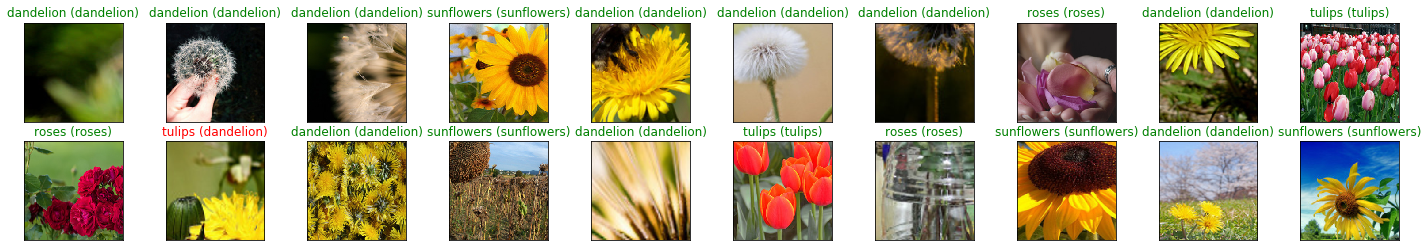

In [28]:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
imagesNumpy = images.numpy() # convertemos a imagem para numpy para podermos visualizá-la

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()



# get sample outputs
output = vgg16New(images)
#convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(imagesNumpy[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## DESAFIO

Pesquise sobre diferentes arquiteturas de redes e proponha um método de classificação de flores que seja o melhor da turma (tendo a métrica de acurácia como referência). **Você precisa utilizar necessariamente este dataset**.

Aqui, vale tudo! Treinar redes do zero, utilizar transfer learning, utilizar outros métodos etc. Utilize tudo ao seu alcance para obter a melhor acurácia sobre o conjunto de testes deste notebook.

Não se esqueça também de imprimir, além da acurácia, todas as demais informações que foram pedidas no exercício deste notebook. Aqui, é obrigatório o uso do conjunto de validação no processo de treinamento. **O conjunto de validação deve ser extraído do conjunto de treinamento, não de teste**. Garanta que os conjuntos estejam sempre balanceados.

**O grupo que conseguir a maior acurácia receberá um ponto extra neste exercício**.

Este notebook foi adaptado do curso Deep Learning Nanodegree da Udacity, cujo repositório está disponível [aqui](https://github.com/udacity/deep-learning-v2-pytorch).